# Assignment : Spam Filter
## Description
This assignment is near-final modulo some small adjustments (6 Nov '16)
In this assignment, you will discover that in many practical machine learning problems implementing the learning algorithm is often only a small part of the overall system. Thus to get a high mark for this assignment you need to implement any of the more advanced classification techniques or clever pre-processing methods. You will find plenty of them on the internet. If you do not know where to look for them, ask Google ;-).

Here your task is to build the standard (i.e. multinomial) Naive Bayes text classifier described during the lectures. You should test your program using the automatic marking software (described below), so it is critically important that it follows the specifications in detail.

You will train your classifier on real-world e-mails, which you can download from here. Each training e-mail is stored in a separate file. The names of spam training e-mails start with spam, while the names of ham e-mails start with ham.

## Marking criteria

Part 1 (40%):
    - Your program classifies the testing set with an accuracy significantly higher than random within 30 minutes
    - Use very simple data preprocessing so that the emails can be read into the Naive Bayes (remove everything else other than words from emails)
    - Write simple Naive Bayes multinomial classifier or use an implementation from a library of your choice
    - Classify the data
    - Report your results with a metric (e.g. accuracy) and method (e.g. cross validation) of your choice
    - Choose a baseline and compare your classifier against it

Part 2 (30%):
    - Use some smart feature processing techniques to improve the classification results
    - Compare the classification results with and without these techniques
    - Analyse how the classification results depend on the parameters (if available) of chosen techniques
    - Compare (statistically) your results against any other algorithm of your choice (use can use any library); compare and contrast results, ensure fair comparison

Part 3 (30%):
    - Calibration (15%): calibrate Naive Bayes probabilities, such that they result in low mean squared error
    - Naive Bayes extension (15%): modify the algorithm in some interesting way (e.g. weighted Naive Bayes)
    

** Convert from .ipynb to .py : ** $ ipython nbconvert --to python filter.ipynb

** BeautifulSoup: ** $ pip install beautifulsoup4




In [1]:
# Import all necessary packages
import math
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import email
import nltk



import os, re




** Part 1 Filtering **

In [2]:

# Removes header from email if present
def get_body(msg):
    if msg.is_multipart():
        for payload in msg.get_payload():
            # if payload.is_multipart(): ...
            return payload.get_payload()
    else:
        return msg.get_payload()
    
    
# Returns text containing only words (lowercase)
def remove_extras(text):
    brackets = "\([^)]*\)"
    email_address = "([\w.-]+)@([\w.-]+)"
    web_address = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    numbers = "\d+"
    alphanumeric = "([^\s\w]|_)+"
    whitespace = "\s+"
    stop_words = '\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*'

    text = re.sub(email_address, '', text)
    text = re.sub(web_address, '', text)
    text = re.sub(numbers, '', text)
    text = re.sub(alphanumeric, '', text)
    text = re.sub(whitespace, ' ', text).strip()
    text = text.lower() # Lowercase
    return text

def simple_html_filter(html_doc):

    soup = BeautifulSoup(str(html_doc), "html.parser")


    for script in soup(["script", "style"]):
        script.extract()    # rip it out
        
    text = soup.get_text()
    return text

def filter_stop_words(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text
    
    
def filter_part1(email): 
    message = get_body(email)
    message = simple_html_filter(message)
    message = remove_extras(message)
    message = filter_stop_words(message)
    return message


# ---------------------

# Example

with open('training_data/ham000.txt') as f:
    text_test = f.read()

msg = email.message_from_string(text_test)

print(filter_part1(msg))



receiving email signed receive one free reports would prefer receive messages type please unsubscribe following instructions bottom message dear investor thank requesting free special report one stock keeps wall street buzzing began motley fool idea investors like deserved better better wall streets alltoooften biased research better analysts speak secret codes allowing hedge spin recommendation better passes full financial disclosure big business today given level playing field believe regular folks like us quite well stock market put trust conflicted information others could count abilities potentially blow pros away two million people visit foolcom web site month spend great deal time foolcom instructing people invest much invest thats created motley fool stock advisor cordially invited join us charter subscriber motley fool stock advisor focus great companies us stock market honest noholdsbarred style made foolcom popular investors well bring best stock recommendations financial in

In [3]:
# from email.header import decode_header
# def getheader(header_text, default="ascii"):
#     """Decode the specified header"""

#     headers = decode_header(header_text)
#     header_sections = [unicode(text, charset or default)
#                        for text, charset in headers]
#     return u"".join(header_sections)


# getheader(msg["from"])

In [13]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 

def do_stemming(text):
    stemmed = ""
    for word in text.split():
#         stemmed += PorterStemmer().stem(word) + " "
        stemmed += LancasterStemmer().stem(word) + " "
    return stemmed

def simple_html_filter(html_doc):

    soup = BeautifulSoup(str(html_doc), "html.parser")

    for elem in soup(["script", "style"]):
        elem.extract()    # rip it out

    text = soup.get_text()
    return text


def filter_part2(email):
    message = get_body(email)
    message = simple_html_filter(message)
    message = remove_extras(message)
    message = filter_stop_words(message)
    essage = do_stemming(message)
    return message 

# ---------------------

# Example

with open('training_data/ham000.txt') as f:
    text_test = f.read()

msg = email.message_from_string(text_test)

print(filter_part2(msg))

receiving email signed receive one free reports would prefer receive messages type please unsubscribe following instructions bottom message dear investor thank requesting free special report one stock keeps wall street buzzing began motley fool idea investors like deserved better better wall streets alltoooften biased research better analysts speak secret codes allowing hedge spin recommendation better passes full financial disclosure big business today given level playing field believe regular folks like us quite well stock market put trust conflicted information others could count abilities potentially blow pros away two million people visit foolcom web site month spend great deal time foolcom instructing people invest much invest thats created motley fool stock advisor cordially invited join us charter subscriber motley fool stock advisor focus great companies us stock market honest noholdsbarred style made foolcom popular investors well bring best stock recommendations financial in

read in all documents and convert to a bag of words

In [5]:
import glob
data = []
training_labels = []
training_label_names = ['ham', 'spam']
        
# ham
for filename in glob.glob('training_data/ham*.txt'):
    f = open(filename, 'r')
    data.append(f.read())
    training_labels.append(0)

# spam    
for filename in glob.glob('training_data/spam*.txt'):
    f = open(filename, 'r')
    data.append(f.read())
    training_labels.append(1)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

class PreProcessor(object):

    def transform(self, X):
        out = []
        isRiskFree = False
        for item in X:
            data = filter_part2(email.message_from_string(item))
            out.append(data)
        return out

    def fit(self, X, y=None):
        return self

text_clf = Pipeline([('preprocess', PreProcessor()),
                     ('vect', CountVectorizer(decode_error='ignore')),
#                      ('tfidf', TfidfTransformer(use_idf=False)),
                     ('clf', MultinomialNB()),
])

Let's test using Stratified Cross Validation:

In [7]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

k = 10
skf = StratifiedKFold(training_labels, n_folds=k)
acc_per_fold = []

for train_indices, test_indices in skf:
    clf = text_clf.fit([data[i] for i in train_indices], [training_labels[i] for i in train_indices])
    predicted = clf.predict([data[i] for i in test_indices])
    acc_per_fold.append( accuracy_score([training_labels[i] for i in test_indices], predicted) )

print "Accuracy per fold:", acc_per_fold
print "Average accuracy:", np.mean(acc_per_fold)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy per fold: [0.93999999999999995, 1.0, 0.93999999999999995, 0.97999999999999998, 0.93999999999999995, 1.0, 1.0, 0.95999999999999996, 1.0, 0.97999999999999998]
Average accuracy: 0.974


And we'll also test using a separate (large) batch of test data

In [14]:
import random
from sklearn.naive_bayes import MultinomialNB
# we're using multinomial because it's most relevant for word counts
text_clf = text_clf.fit(data, training_labels)

def pickTestData(count=1):
    labelsFile = open('testdata.label', 'r')
    labeling = labelsFile.readlines()
    random.shuffle(labeling)
    sample = labeling[0:count]
    return [(open('test_data/'+row.split()[1], 'r').read(), 1-int(row.split()[0])) for row in sample]

test_data = pickTestData(3000)
# test_data = pickTestData(200)

docs_new = [i[0] for i in test_data]

predicted = text_clf.predict(docs_new)

accuracy = accuracy_score([item[1] for item in test_data], predicted)

print "Accuracy against test data:", accuracy

Accuracy against test data: 0.834333333333


Confusion matrix, without normalization
[[135   1]
 [ 34  30]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.53  0.47]]


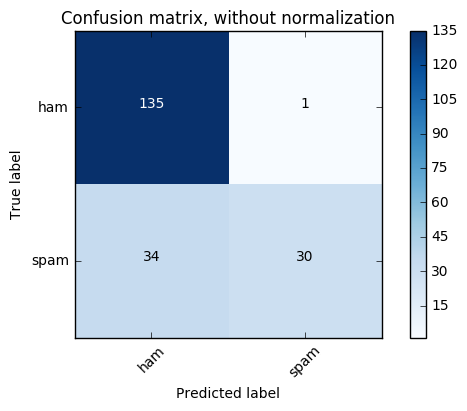

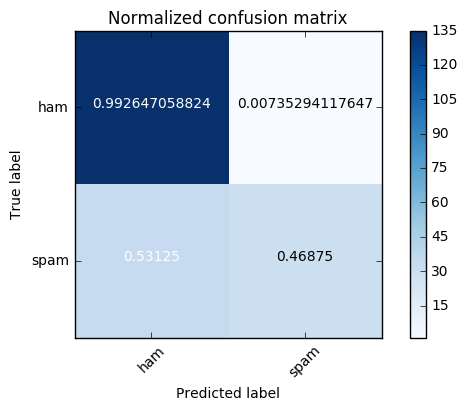

In [9]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix([item[1] for item in test_data], predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=training_label_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=training_label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()